# CS5483 Data Warehousing and Data Mining Project

*Author: Group1**Author: group1*

## Table of Contents

* [Abstract](#abstract)
* [Part1. Introduction](#chapter1)
* [Part2. Data Process and Description](#chapter2)
    * [2.1 Pre-processing](#section_2_1)
    * [2.2 Preliminary data analysis](#section_2_2)
    * [2.3 Variable correlation analysis](#section_2_3)
* [Part3. Model](#chapter3)
    * [3.1 Normalization](#section_3_1)
    * [3.2 Feature Extraction](#section_3_2)
    * [3.3 Dimensionality reduction](#section_3_3)
* [Part4. Model](#chapter4)
    * [4.1 Random Forest](#section_4_1)
    * [4.2 Naive Bayes](#section_4_2)
    * [4.3 InceptionV3 Model](#section_4_3)
    * [4.4 CNN Neural Network](#section_4_4)
        * [4.4.1 Optimizer & Loss Function](#section_4_4_1)
        * [4.4.2 Training our CNN Model](#section_4_4_2)
        * [4.4.3 Check the performance of our CNN model ](#section_4_4_3)
        * [4.4.4 Look at the wrong images](#section_4_4_4)
        * [4.4.5 Hyper-parameter tuning](#section_4_4_5)
        * [4.4.6 Boarder Deeper Network](#section_4_4_6)
* [Part5. Conclusion](#chapter5)

# Abstract <a id="abstract"></a>

- In data loading and data processing, we first preprocess the data to eliminate duplicate and abnormal data. Then, in the data description part, the variables are preliminarily described, and the correlation between variables is simply analyzed

# Part 1. Introduction <a id="chapter1"></a>

- According to the CDC, heart disease is one of the leading causes of death for people of most races in the US (African Americans, American Indians and Alaska Natives, and white people). About half of all Americans (47%) have at least 1 of 3 key risk factors for heart disease: high blood pressure, high cholesterol, and smoking. Other key indicators include diabetic status, obesity (high BMI), not getting enough physical activity or drinking too much alcohol. Detecting and preventing the factors that have the greatest impact on heart disease is very important in healthcare. Computational developments, in turn, allow the application of machine learning methods to detect "patterns" from the data that can predict a patient's condition.

- The dataset come from the CDC and is a major part of the Behavioral Risk Factor Surveillance System (BRFSS), which conducts annual telephone surveys to gather data on the health status of U.S. residents. As the CDC describes: "Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.". The most recent dataset (as of February 15, 2022) includes data from 2020. It consists of 401,958 rows and 279 columns. The vast majority of columns are questions asked to respondents about their health status.

# Part 2.Data Process and Description <a id="chapter2"></a>

##  Import dependences

In [1]:
# import package
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster, leaders
from scipy.cluster import hierarchy
from scipy.sparse import csr_matrix
import networkx as nx
import seaborn as sns
import math

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge
import warnings
sns.set_style("white")
%store -r

## 2.1 Pre-processing  <a id="section_2_1"></a>

In [4]:
# import source data
heart_df = pd.read_csv('./data/heart_2020_cleaned.csv')

In [5]:
#De duplication, de unmaned, de Nan
#When keep = 'first', keep the sample when the label appears for the first time, and discard all repeated labels.
#When inplace = false, return the dataframe after removing duplicates, and the original dataframe will not be changed.
# dropna(axis=1,how='all'). Dropna (axis = 0, how ='Any ') deletes columns that are all Nan and any rows with Nan
def cleanData(data):
    cleaned_data = data.drop_duplicates(keep='first',inplace=False).loc[:, ~data.columns.str.contains("^Unnamed")].dropna(axis=1,how='all').dropna(axis=0, how='any')
    return cleaned_data

In [6]:
# clean data
heart_df=cleanData(heart_df)

## 2.2 Preliminary data analysis  <a id="section_2_2"></a>

In [7]:
# Dataset's information
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26247 entries, 0 to 26380
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      26247 non-null  object 
 1   BMI               26247 non-null  float64
 2   Smoking           26247 non-null  object 
 3   AlcoholDrinking   26247 non-null  object 
 4   Stroke            26247 non-null  object 
 5   PhysicalHealth    26247 non-null  float64
 6   MentalHealth      26247 non-null  float64
 7   DiffWalking       26247 non-null  object 
 8   Sex               26247 non-null  object 
 9   AgeCategory       26247 non-null  object 
 10  Race              26247 non-null  object 
 11  Diabetic          26247 non-null  object 
 12  PhysicalActivity  26247 non-null  object 
 13  GenHealth         26247 non-null  object 
 14  SleepTime         26247 non-null  float64
 15  Asthma            26247 non-null  object 
 16  KidneyDisease     26247 non-null  object

In [8]:
def countp(var):

    # Plot
    fig,ax = plt.subplots(figsize=(20,10), dpi= 200)
    sns.countplot(data = heart_df, x=var, palette='Set1')

    # Personalization
    plt.title('Heart Disease', fontsize=18)
    plt.xticks(rotation=0, fontsize=16, horizontalalignment='center', alpha=.7)
    plt.yticks(fontsize=14, alpha=.7)
    plt.grid(axis='both', alpha=.3)
    ax.set_xlabel('', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)

    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    return plt.show()

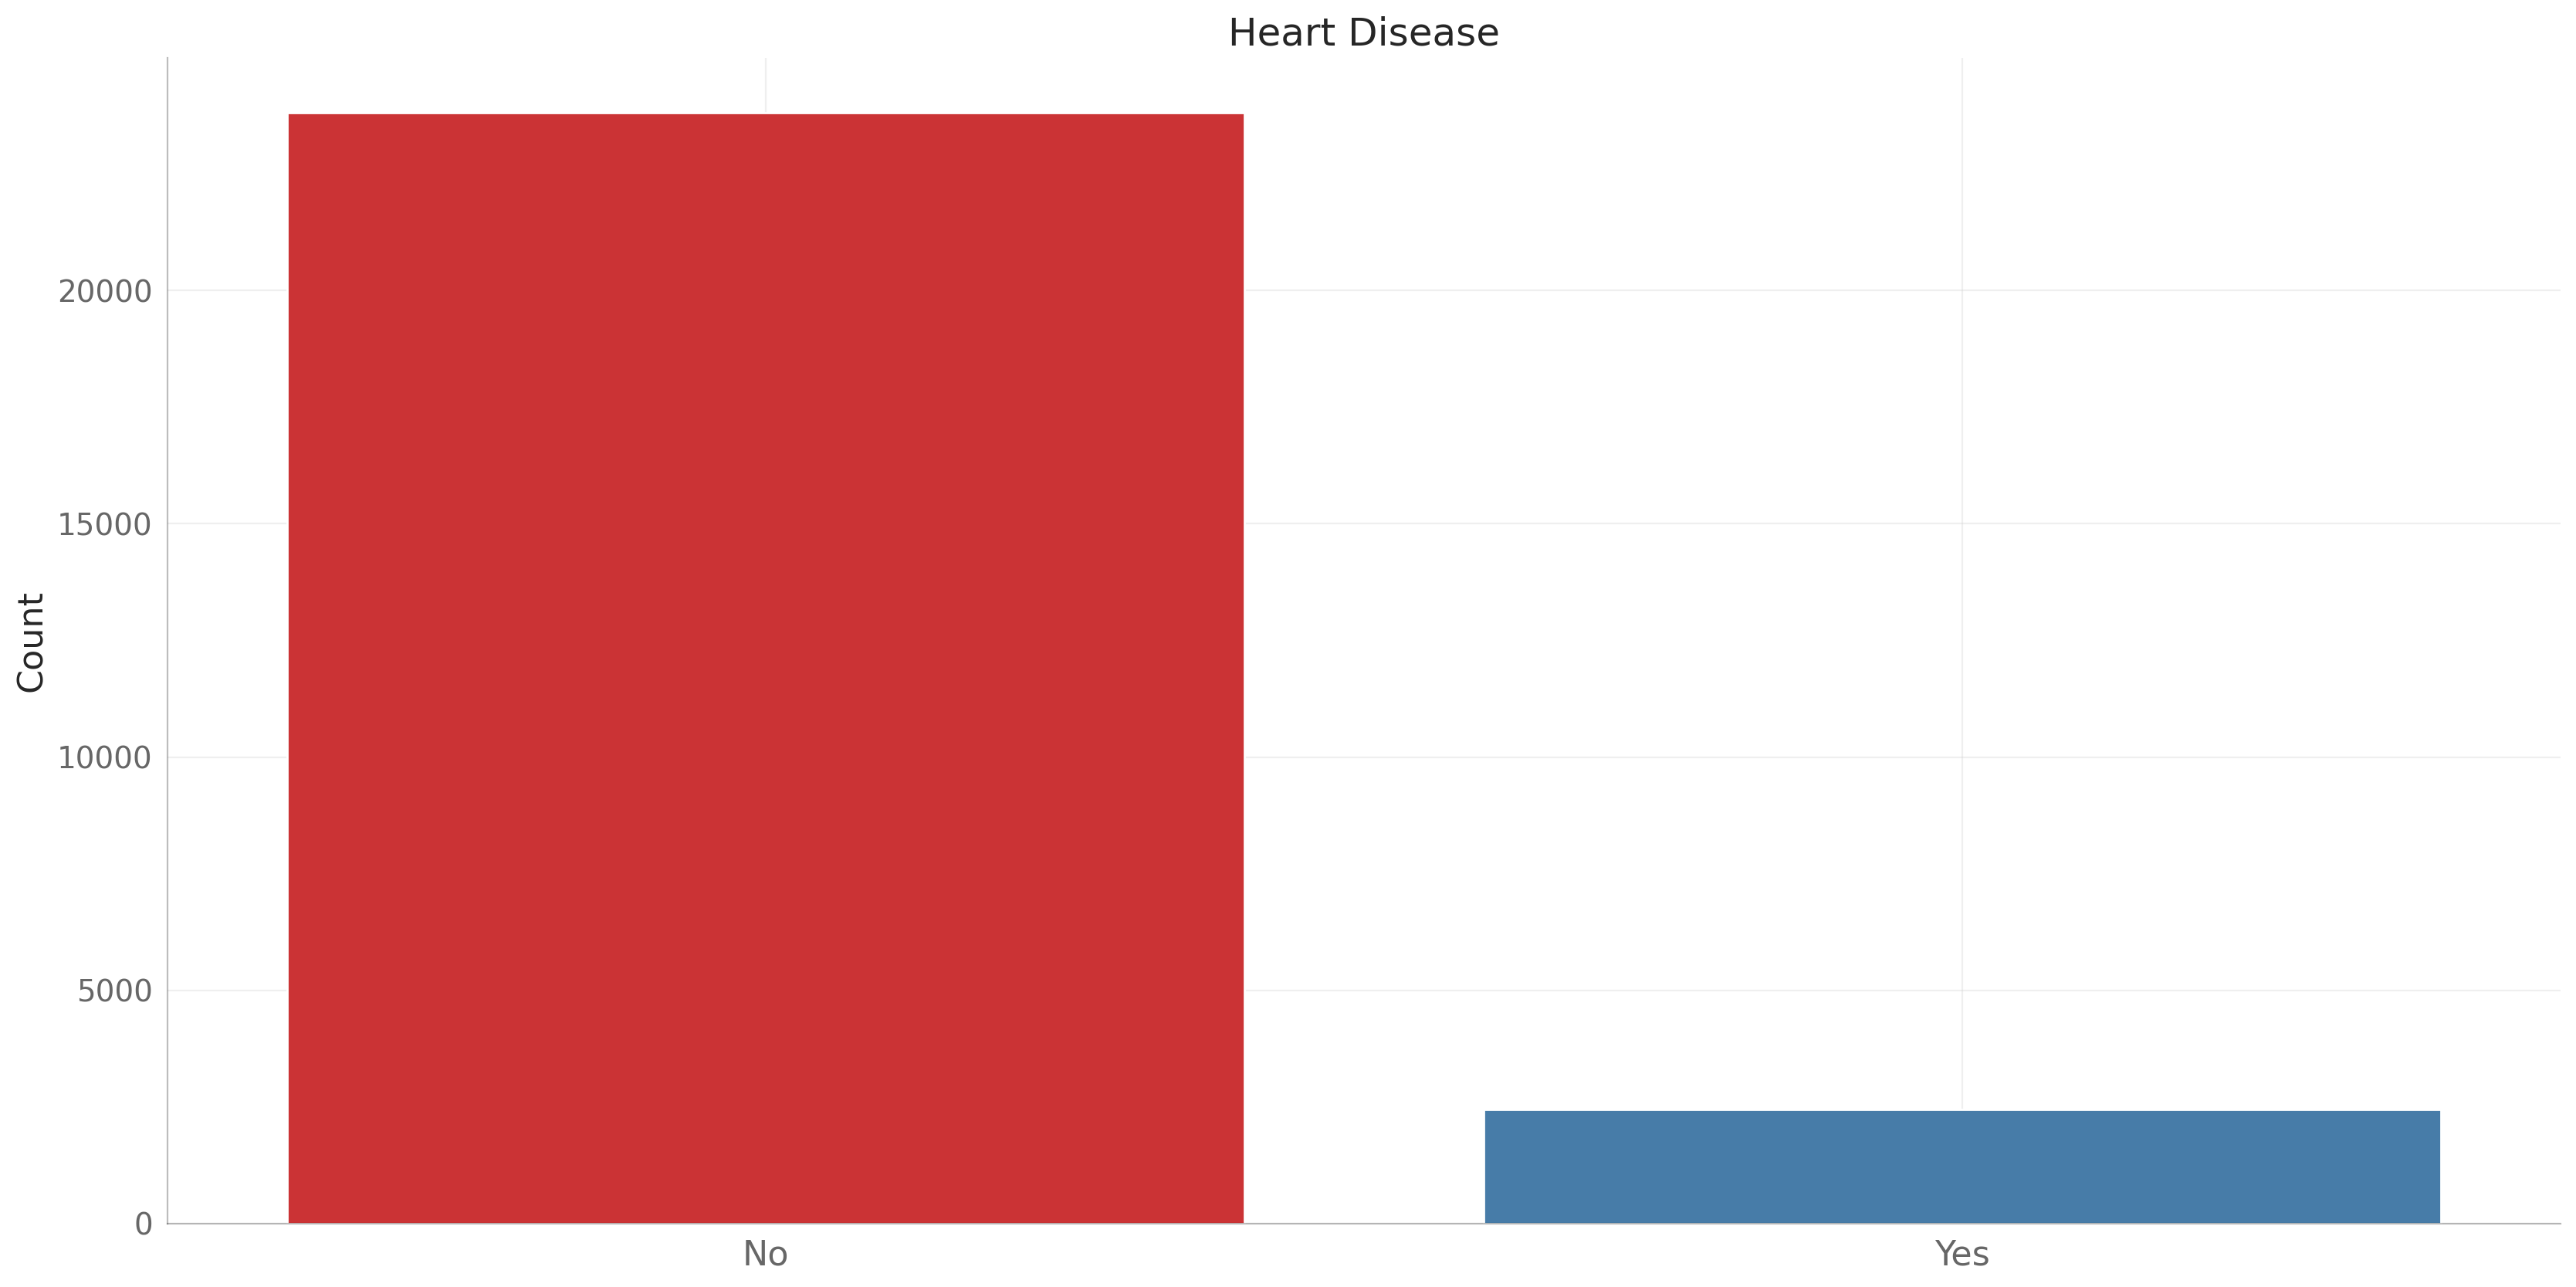

In [9]:
# Countplot for the variable "HeartDisease"
countp(var='HeartDisease')

The figure above shows a significant imbalance between people with and without heart disease in the data set. Therefore, the EDA of classified data will use standardized values.

In [10]:
def barp(var, order=None):

    # Plot
    data_normalized = heart_df.groupby(f'{var}')['HeartDisease'].value_counts(normalize=True).rename('Percentage').mul(100).reset_index().sort_values(f'{var}')

    fig,ax = plt.subplots(figsize=(20,10), dpi= 200)
    sns.barplot(x=var, y='Percentage', hue='HeartDisease', data=data_normalized, order=order, palette='Set1')

    # Personalization
    plt.xticks(rotation=0, fontsize=16, horizontalalignment='center', alpha=.7)
    plt.yticks(fontsize=14, alpha=.7)
    plt.grid(axis='both', alpha=.3)
    plt.title('Heart Disease', fontsize=18)
    ax.set_xlabel(f'{var}', fontsize=18)
    ax.set_ylabel('Percentage (%)', fontsize=18)
    ax.legend(frameon=False, ncol=len(heart_df.columns), fontsize='xx-large')

    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)

    return plt.show()

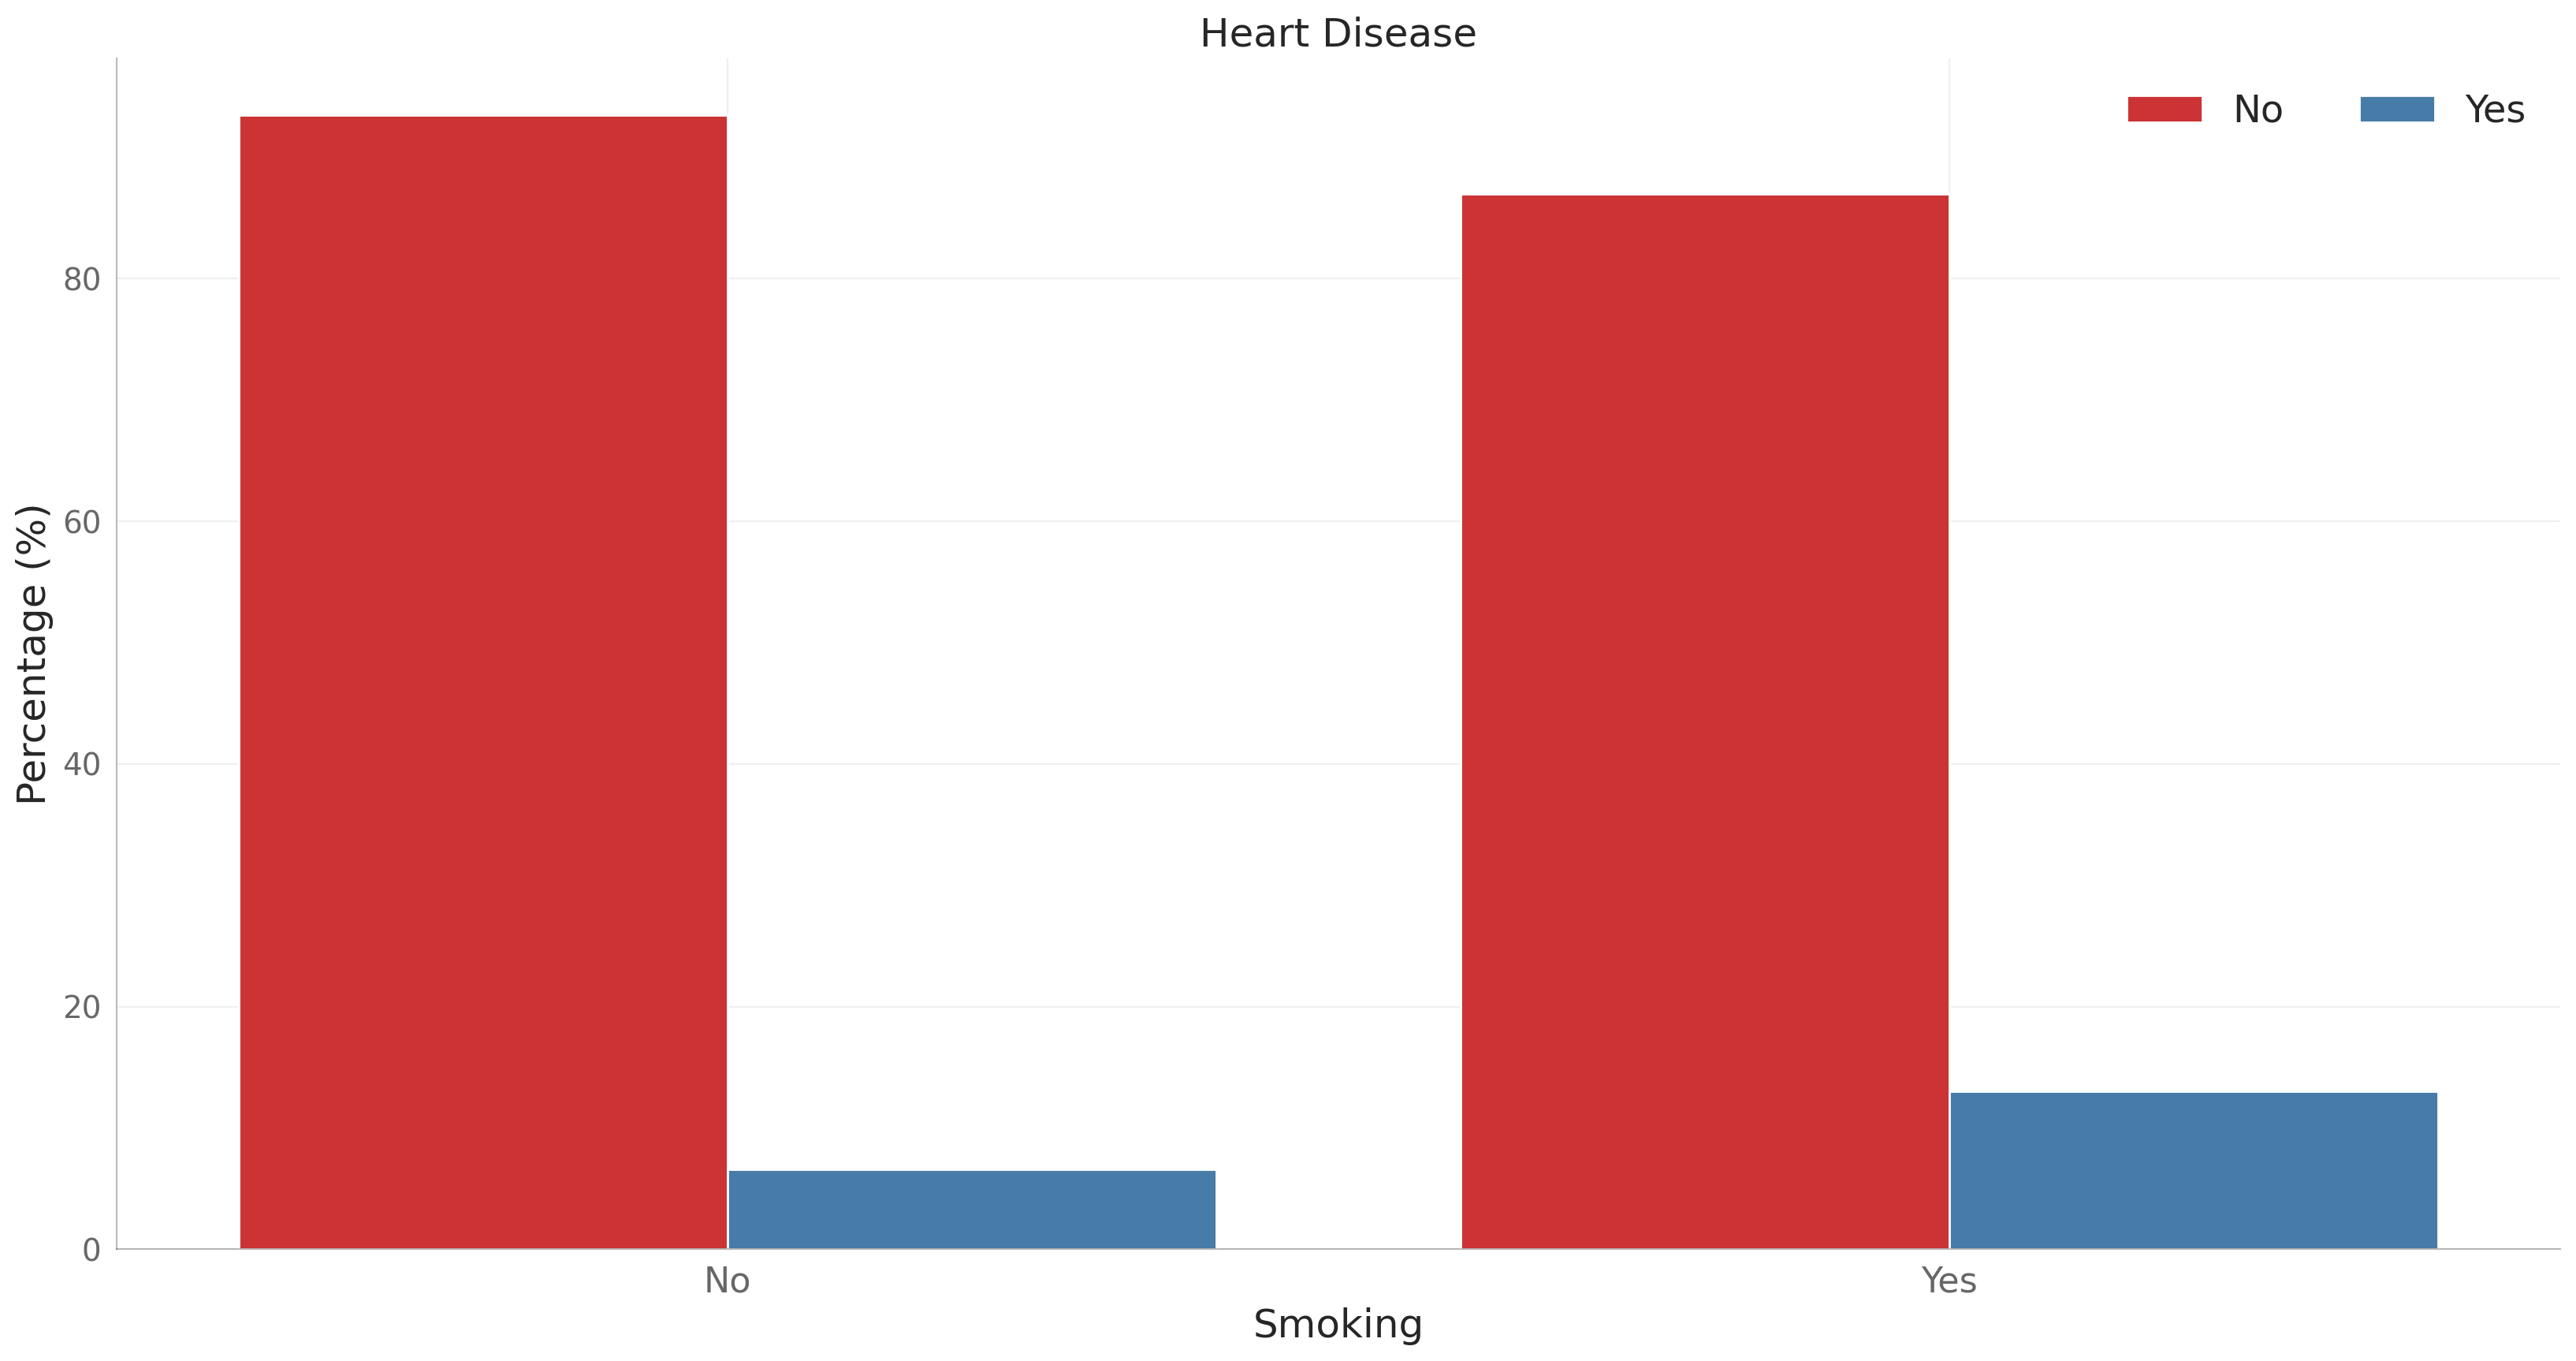

In [11]:
# Barplot for "Smoking"
barp('Smoking')

The chart above shows the significant prevalence of heart disease in people with smoking habits.

In [12]:
def barp(var, order=None):
    # Plot
    data_normalized = heart_df.groupby(f'{var}')['HeartDisease'].value_counts(normalize=True).rename('Percentage').mul(100).reset_index().sort_values(f'{var}')
    fig,ax = plt.subplots(figsize=(20,10), dpi= 200)
    sns.barplot(x=var, y='Percentage', hue='HeartDisease', data=data_normalized, order=order, palette='Set1')
    # Personalization
    plt.xticks(rotation=0, fontsize=16, horizontalalignment='center', alpha=.7)
    plt.yticks(fontsize=14, alpha=.7)
    plt.grid(axis='both', alpha=.3)
    plt.title('Heart Disease', fontsize=18)
    ax.set_xlabel(f'{var}', fontsize=18)
    ax.set_ylabel('Percentage (%)', fontsize=18)
    ax.legend(frameon=False, ncol=len(heart_df.columns), fontsize='xx-large')
    plt.gca().spines["top"].set_alpha(0.0)    
    plt.gca().spines["bottom"].set_alpha(0.3)
    plt.gca().spines["right"].set_alpha(0.0)    
    plt.gca().spines["left"].set_alpha(0.3)
    return plt.show()

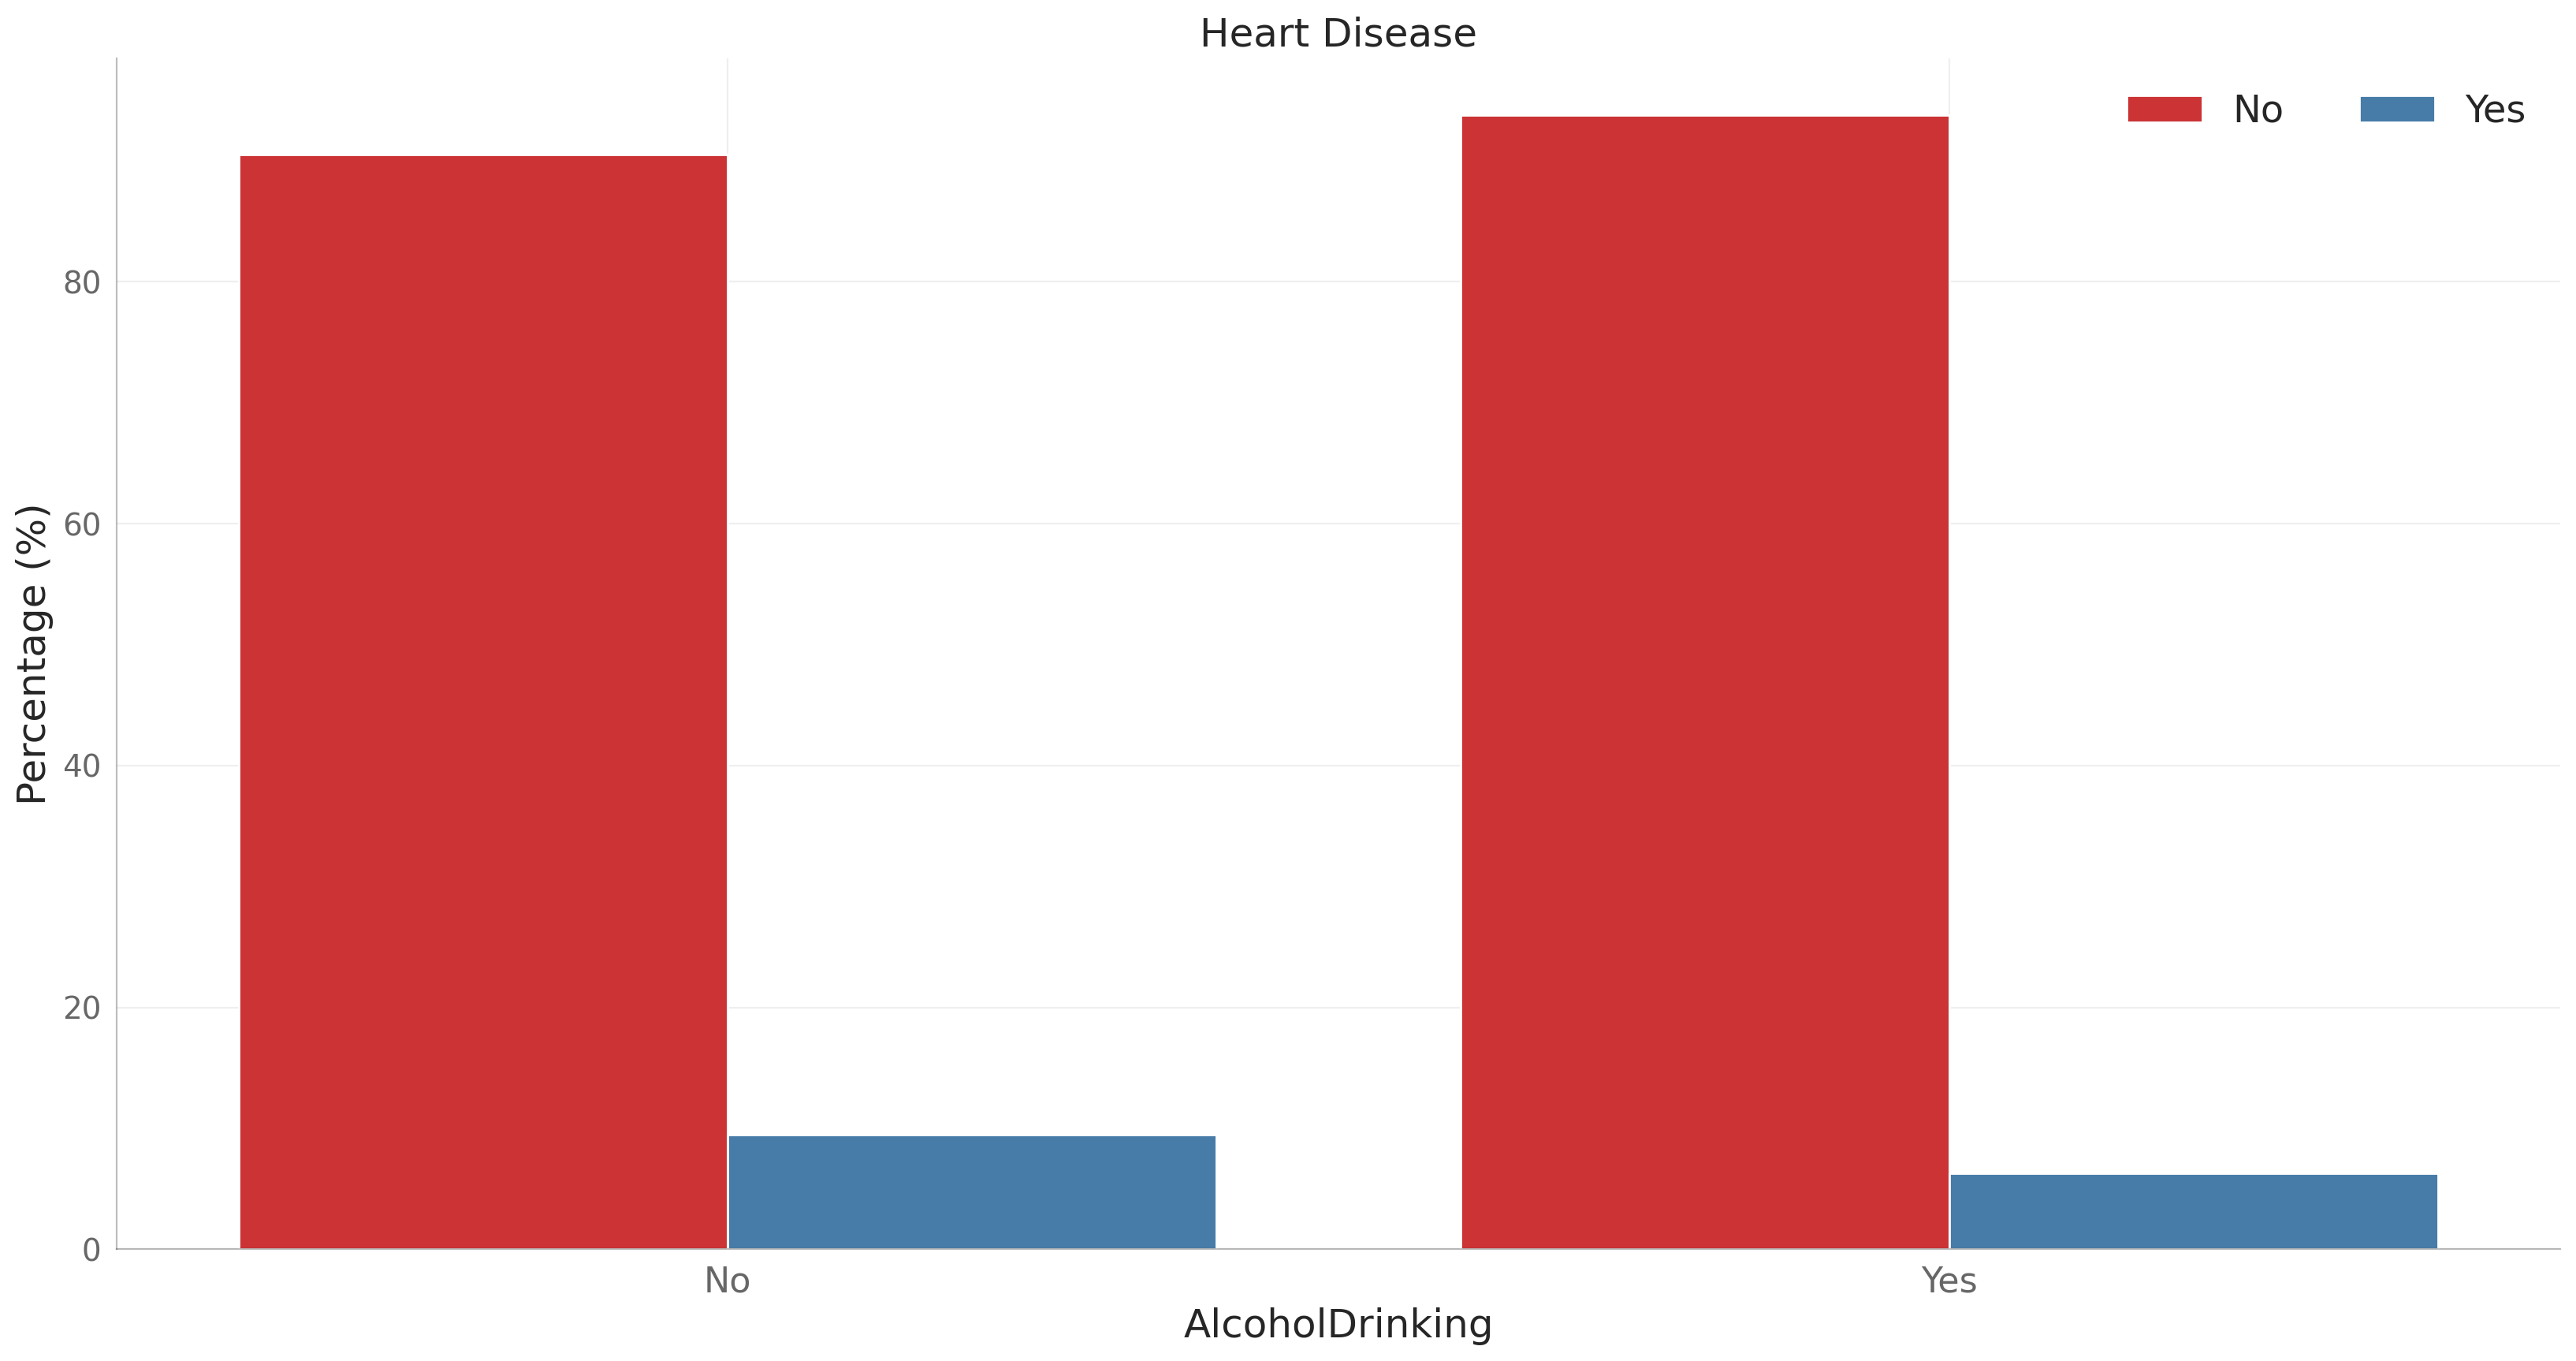

In [13]:
# Barplot for "AlcoholDrinking"
barp('AlcoholDrinking')

The chart shows that the prevalence of heart disease is very high for people who do not drink alcohol.

Description of each variable in the dataset:

| Variable | Description | 
|:------:|:------:|
| HeartDisease | Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI)|
| BMI | Body Mass Index (BMI)|
| Smoking | Have you smoked at least 100 cigarettes in your entire life? 
| AlcoholDrinking | Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week|
| Stroke | (Ever told) (you had) a stroke?|
| PhysicalHealth | How many days during the past 30 days was your physical health not good?|
| MentalHealth | How many days during the past 30 days was your mental health not good?|
| DiffWalking | Do you have serious difficulty walking or climbing stairs?|
| Sex | Are you male or female?|
| AgeCategory | Fourteen-level age category|
| Race | Imputed race/ethnicity value|
| Diabetic | (Ever told) (you had) diabetes?|
| PhysicalActivity | Adults who reported doing physical activity or exercise during the past 30 days other than their regular job|
| GenHealth | Would you say that in general your health is...|
| SleepTime | On average, how many hours of sleep do you get in a 24-hour period?|
| Asthma | (Ever told) (you had) asthma?|
| KidneyDisease | Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?|
| SkinCancer | (Ever told) (you had) skin cancer?|

## 2.3 Variable correlation analysis <a id="section_2_3"></a>

In [14]:
def data_convert(df):
    if type(df)!=pd.core.frame.DataFrame:
        raise ValueError('input is not a pandas dataframe')
    working_df = df.copy()
    cols = working_df.columns
    converted_columns = {}
    for col in cols:
        if working_df[col].dtype == 'O':
            unique_values = working_df[col].unique()
            converted_values = {v:k for k,v in enumerate(unique_values)}
            for value in unique_values:
                working_df[col] = working_df[col].replace(value, converted_values[value])
            converted_columns[col] = converted_values
    return working_df, converted_columns

In [15]:
cleaned_df, conversion_index = data_convert(heart_df)

<AxesSubplot:>

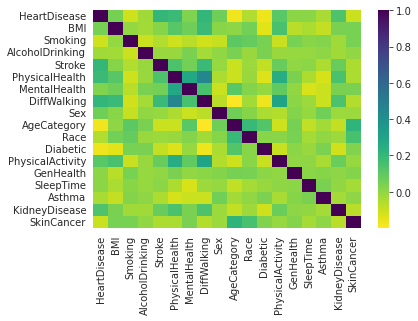

In [16]:
sns.heatmap(cleaned_df.corr(), cmap='viridis_r')

Using the thermodynamic diagram, we can intuitively see the correlation between various variables. It can be seen that diffwalking is highly correlated with physical health. The correlation between heartdisease and agecategory is small.

# Part 3.Model establishment and algorithm analysis <a id="chapter2"></a>